In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest,f_classif, VarianceThreshold
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('../data/interim/train_clean_ordinal.csv')

In [3]:
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Census_OSBranch_release_extracted,EngineVersion_encoded,AppVersion_encoded,AvSigVersion_encoded,Census_OSVersion_encoded
0,win8defender,7.0,0,53447.0,1.0,1.0,1,94,65823.0,NaN,...,0,0.0,0.0,11.0,0,rs4_release,31,14,30,11
1,win8defender,7.0,0,23657.0,2.0,1.0,1,139,87570.0,NaN,...,0,0.0,1.0,1.0,0,rs4_release,30,14,29,11
2,win8defender,7.0,0,23962.0,2.0,1.0,1,123,94381.0,NaN,...,0,0.0,0.0,5.0,0,rs4_release,31,14,30,11
3,win8defender,7.0,0,46669.0,2.0,1.0,1,85,NaN,27.0,...,0,0.0,0.0,10.0,1,th2_release,30,5,29,2
4,win8defender,7.0,0,53447.0,1.0,1.0,1,50,105713.0,27.0,...,0,0.0,0.0,3.0,1,rs4_release,30,14,29,11


In [4]:
df.shape

(89212, 66)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89212 entries, 0 to 89211
Data columns (total 66 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ProductName                                        89211 non-null  object 
 1   RtpStateBitfield                                   88876 non-null  float64
 2   IsSxsPassiveMode                                   89212 non-null  int64  
 3   AVProductStatesIdentifier                          88847 non-null  float64
 4   AVProductsInstalled                                88847 non-null  float64
 5   AVProductsEnabled                                  88847 non-null  float64
 6   HasTpm                                             89212 non-null  int64  
 7   CountryIdentifier                                  89212 non-null  int64  
 8   CityIdentifier                                     85949 non-null  float64
 9   Organi

In [6]:
train_df = df.copy()

In [7]:
col_nan = train_df.isnull().mean()
col_nan.sort_values(ascending=False)[:10]

SmartScreen                              0.358730
OrganizationIdentifier                   0.306360
CityIdentifier                           0.036576
Wdft_RegionIdentifier                    0.032944
Wdft_IsGamer                             0.032944
Census_InternalBatteryNumberOfCharges    0.030332
Census_FirmwareManufacturerIdentifier    0.021286
Census_FirmwareVersionIdentifier         0.018596
Census_OEMModelIdentifier                0.012263
Census_OEMNameIdentifier                 0.011366
dtype: float64

In [8]:
categorical_columns = train_df.select_dtypes('object').columns.tolist()
binary_columns = [col for col in train_df.columns.tolist() if train_df[col].nunique() <= 2 if train_df[col].dtypes != 'O']
true_numerical_columns = ['Census_ProcessorCoreCount',
                          'Census_PrimaryDiskTotalCapacity',
                           'Census_SystemVolumeTotalCapacity',
                           'Census_TotalPhysicalRAM',
                           'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                           'Census_InternalPrimaryDisplayResolutionHorizontal',
                           'Census_InternalPrimaryDisplayResolutionVertical',
                           'Census_InternalBatteryNumberOfCharges']
encoded_columns = [col for col in train_df.columns if 'encoded' in col]
numerical_columns = true_numerical_columns + encoded_columns
cat_num_columns = [col for col in train_df.columns.tolist() 
                   if col not in numerical_columns 
                   if col not in binary_columns 
                   if col not in categorical_columns]
tot_columns = numerical_columns + binary_columns + categorical_columns + cat_num_columns
len(categorical_columns), len(binary_columns), len(numerical_columns), len(cat_num_columns), len(tot_columns)

(20, 10, 13, 23, 66)

In [9]:
col_n_uniq = train_df[categorical_columns].nunique()
col_n_uniq.sort_values(ascending=False)

Census_OSBranch_release_extracted    19
Census_ChassisTypeName               15
Census_OSEdition                     12
Census_MDC2FormFactor                11
Census_OSSkuName                     11
Census_OSInstallTypeName              9
Census_PowerPlatformRoleName          9
OsPlatformSubRelease                  9
SmartScreen                           8
SkuEdition                            8
Census_FlightRing                     7
Census_OSWUAutoUpdateOptionsName      6
Census_ActivationChannel              6
Platform                              4
Census_GenuineStateName               4
Census_PrimaryDiskTypeName            3
Census_DeviceFamily                   2
Census_OSArchitecture                 2
Processor                             2
ProductName                           2
dtype: int64

In [10]:
train = train_df.copy()
train.shape

(89212, 66)

In [11]:
train.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Census_OSBranch_release_extracted,EngineVersion_encoded,AppVersion_encoded,AvSigVersion_encoded,Census_OSVersion_encoded
0,win8defender,7.0,0,53447.0,1.0,1.0,1,94,65823.0,NaN,...,0,0.0,0.0,11.0,0,rs4_release,31,14,30,11
1,win8defender,7.0,0,23657.0,2.0,1.0,1,139,87570.0,NaN,...,0,0.0,1.0,1.0,0,rs4_release,30,14,29,11
2,win8defender,7.0,0,23962.0,2.0,1.0,1,123,94381.0,NaN,...,0,0.0,0.0,5.0,0,rs4_release,31,14,30,11
3,win8defender,7.0,0,46669.0,2.0,1.0,1,85,NaN,27.0,...,0,0.0,0.0,10.0,1,th2_release,30,5,29,2
4,win8defender,7.0,0,53447.0,1.0,1.0,1,50,105713.0,27.0,...,0,0.0,0.0,3.0,1,rs4_release,30,14,29,11


In [12]:
train.dtypes

ProductName                           object
RtpStateBitfield                     float64
IsSxsPassiveMode                       int64
AVProductStatesIdentifier            float64
AVProductsInstalled                  float64
                                      ...   
Census_OSBranch_release_extracted     object
EngineVersion_encoded                  int64
AppVersion_encoded                     int64
AvSigVersion_encoded                   int64
Census_OSVersion_encoded               int64
Length: 66, dtype: object

In [13]:
'HasDetections' in tot_columns

True

In [14]:
target_index = tot_columns.index('HasDetections')
target_name = tot_columns.pop(target_index)

In [15]:
'HasDetections' in tot_columns

False

In [16]:
'HasDetections' in binary_columns

True

In [17]:
idx = binary_columns.index('HasDetections')
binary_columns.pop(idx)

'HasDetections'

In [18]:
'HasDetections' in binary_columns

False

In [19]:
X = train[tot_columns]
y = train[target_name]

In [20]:
#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state = 10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(71369, 65)
(17843, 65)
(71369,)
(17843,)


In [21]:
y_train.mean(), y_test.mean()

(0.5001751460718239, 0.5040632180687105)

In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for binary data
binary_transformer = SimpleImputer(strategy='most_frequent')

# Preprocessing for categorical data encoded as numerical ID's
categorical_num_transformer = SimpleImputer(strategy='most_frequent')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('bin', binary_transformer, binary_columns),
        ('cat_num', categorical_num_transformer, cat_num_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [22]:
# Define model
rf_clf = RandomForestClassifier(random_state = 42)
VarThresh = VarianceThreshold()
#selector = SelectKBest(f_classif)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('VarThresh', VarThresh),
                              #('selector', selector),
                              ('classifier', rf_clf)
                             ])


n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 12, num = 6)]
max_depth.append(None)
min_samples_split = [2, 3, 5, 7, 10, 12, 15]
min_samples_leaf = [1, 2, 3, 4, 5, 7, 10, 12, 15]
bootstrap = [True, False]

parameters = {#'selector__k': [50, 70, 90, 110, 130],
              'preprocessor__num__strategy': ['mean', 'median', 'constant'],
              'preprocessor__bin__strategy': ['most_frequent', 'constant'],
              'preprocessor__cat_num__strategy': ['most_frequent', 'constant'],
              'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
              'classifier__n_estimators': n_estimators,
              'classifier__max_features' : max_features,
              'classifier__max_depth': max_depth,
              'classifier__min_samples_split': min_samples_split,
              'classifier__min_samples_leaf': min_samples_leaf,
              'classifier__bootstrap': bootstrap}

# Grid search
my_grid = RandomizedSearchCV(estimator=my_pipeline, 
                             param_distributions=parameters,
                             n_iter = 15,
                             cv=3,
                             scoring = 'roc_auc',
                             return_train_score=True,
                             #n_jobs = -1,
                             verbose=3)

# Preprocessing of training data, fit model 
my_grid.fit(X_train, y_train)

# optimized model
opt_rf_clf = my_grid.best_estimator_
my_grid.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END classifier__bootstrap=False, classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=7, classifier__n_estimators=3000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=0.665, test=0.663) total time=  54.9s
[CV 2/3] END classifier__bootstrap=False, classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=7, classifier__n_estimators=3000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=0.665, test=0.665) total time=  53.7s
[CV 3/3] END classifier__bootstrap=False, classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples

[CV 3/3] END classifier__bootstrap=True, classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=3000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=median;, score=(train=0.670, test=0.666) total time=  44.3s
[CV 1/3] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=7, classifier__n_estimators=3000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=constant, preprocessor__num__strategy=median;, score=(train=1.000, test=0.688) total time=11.0min
[CV 2/3] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=7, clas

[CV 2/3] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=3000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=constant;, score=(train=0.809, test=0.693) total time= 5.2min
[CV 3/3] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=3000, preprocessor__bin__strategy=constant, preprocessor__cat__imputer__strategy=constant, preprocessor__cat_num__strategy=most_frequent, preprocessor__num__strategy=constant;, score=(train=0.809, test=0.690) total time= 5.2min
[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=auto, classifier__min_samples_leaf=10, classifier__min_samples_split=1

{'preprocessor__num__strategy': 'mean',
 'preprocessor__cat_num__strategy': 'constant',
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__bin__strategy': 'constant',
 'classifier__n_estimators': 1000,
 'classifier__min_samples_split': 15,
 'classifier__min_samples_leaf': 10,
 'classifier__max_features': 'auto',
 'classifier__max_depth': None,
 'classifier__bootstrap': True}

In [23]:
from sklearn.metrics import roc_auc_score

# Predictions
y_pred_train = opt_rf_clf.predict(X_train)
y_pred_test = opt_rf_clf.predict(X_test)

print('Train Set roc auc:', roc_auc_score(y_train, y_pred_train))
print('Test Set roc auc:', roc_auc_score(y_test, y_pred_test))

Train Set roc auc: 0.8140429112117267
Test Set roc auc: 0.6429800276438985


In [24]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64      8849
           1       0.65      0.64      0.64      8994

    accuracy                           0.64     17843
   macro avg       0.64      0.64      0.64     17843
weighted avg       0.64      0.64      0.64     17843



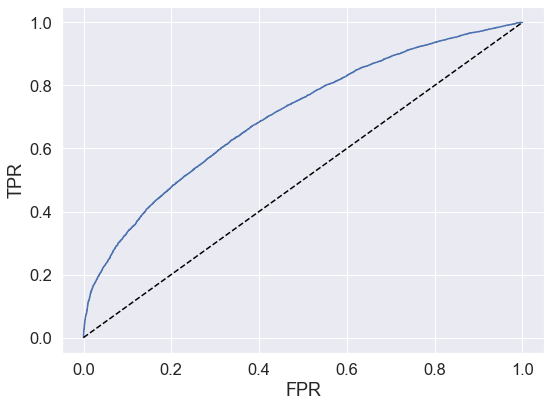

In [25]:
# plot ROC_AUC
import matplotlib.pyplot as plt 
import matplotlib as mpl 
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(font_scale=1.5)

from sklearn import metrics

y_pred_proba_test = opt_rf_clf.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.tight_layout()

Text(0.5, 1.0, 'Confusion matrix')

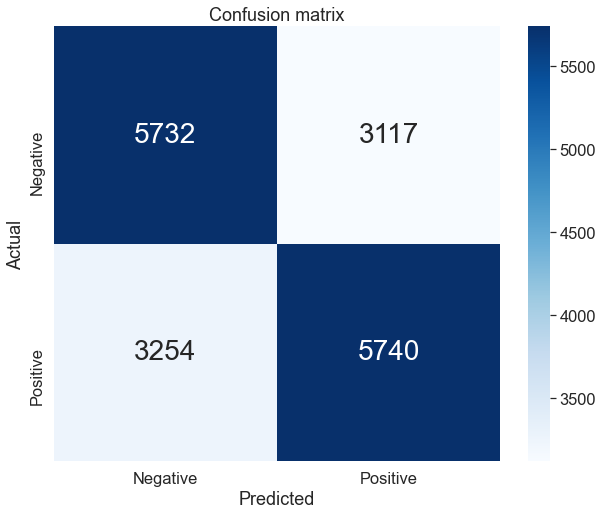

In [26]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_test)

lables = {'Negative': 0, 'Positive': 1} 

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, 
            annot=True,
            annot_kws={'size':28},
            fmt="d",
            xticklabels=lables.keys(), 
            yticklabels=lables.keys(),
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

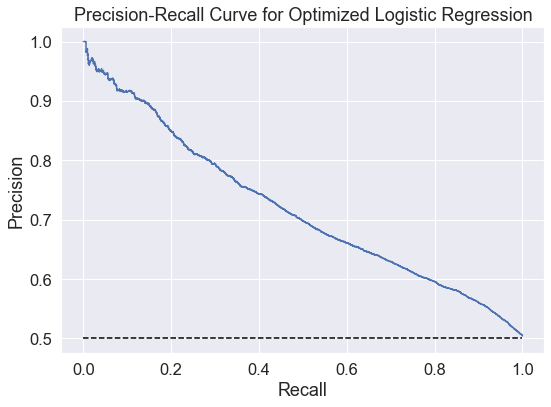

In [27]:
# plot precision - recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.plot([0, 1], [0.5, 0.5], '--', color = 'black')
plt.title('Precision-Recall Curve for Optimized Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()

In [36]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for binary data
binary_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data encoded as numerical ID's
categorical_num_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('bin', binary_transformer, binary_columns),
        ('cat_num', categorical_num_transformer, cat_num_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('VarThresh', VarThresh),
                              #('selector', selector),
                              ('classifier', rf_clf)
                             ])

In [37]:
X_values = preprocessor.fit_transform(X_train)
onehot_cat_columns = my_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_columns)
#onehot_cat_num_columns = my_pipeline.named_steps['preprocessor'].named_transformers_['cat_num'].named_steps['onehot'].get_feature_names(input_features=cat_num_columns)
onehot = onehot_cat_columns.tolist() #+ onehot_cat_num_columns.tolist() 
columns_tot = numerical_columns + binary_columns + cat_num_columns + onehot

feature_importance = pd.Series(data=opt_rf_clf.named_steps['classifier'].feature_importances_, index = np.array(columns_tot))

In [39]:
feature_importance.sort_values(ascending=False)

SmartScreen_ExistsNotSet                          0.099707
AVProductStatesIdentifier                         0.044651
Census_SystemVolumeTotalCapacity                  0.041800
CityIdentifier                                    0.038246
Census_FirmwareVersionIdentifier                  0.037652
                                                    ...   
Census_OSArchitecture_missing_value               0.000000
SmartScreen_&#x0_                                 0.000000
Census_FlightRing_Disabled                        0.000000
Census_PowerPlatformRoleName_PerformanceServer    0.000000
Census_ChassisTypeName_missing_value              0.000000
Length: 200, dtype: float64

In [40]:
std = np.std([tree.feature_importances_ for tree in opt_rf_clf.named_steps['classifier'].estimators_], axis=0)

In [46]:
imp_df = pd.DataFrame(list(zip(feature_importance, std)), columns=['Importance', 'std'], index=feature_importance.index)
imp_df_sorted = imp_df.sort_values(by='Importance', ascending=True).reset_index()
imp_df_sorted.head(100)

,index,Importance,std
0,Census_MDC2FormFactor_LargeServer,0.000000,0.000000
1,Census_OSArchitecture_missing_value,0.000000,0.000000
2,Census_PowerPlatformRoleName_PerformanceServer,0.000000,0.000000
3,ProductName_missing_value,0.000000,0.000000
4,Census_ChassisTypeName_missing_value,0.000000,0.000000
...,...,...,...
95,Census_OSBranch_release_extracted_th2_release_sec,0.000531,0.000439
96,Firewall,0.000562,0.000544
97,Census_IsPenCapable,0.000626,0.000592
98,SmartScreen_Warn,0.000666,0.000808


In [47]:
imp_df_sorted.shape

(200, 3)

In [48]:
#plt.figure(figsize=(20,300))
#sns.barplot(y='index', x='Importance', data = imp_df_sorted, orient='h')

<AxesSubplot:ylabel='index'>

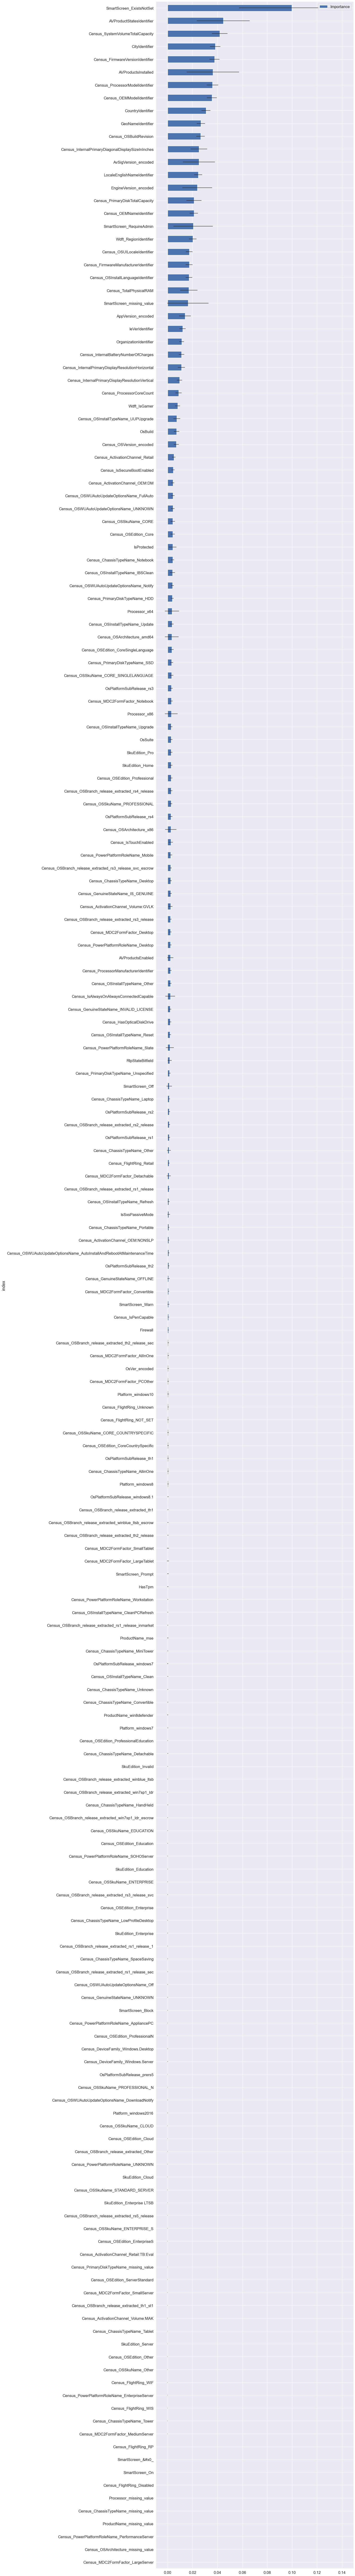

In [50]:
imp_df_sorted.plot(kind='barh', y='Importance', x='index' , xerr='std', figsize=(15,200))

In [51]:
import pickle

In [52]:
pickle.dump(opt_rf_clf, open("../models/optimized_RF.pickle", "wb"))

In [ ]:
X_train_full = [X_train, X_test]
y_train_full= [y_train, y_test]

X_train_full = pd.concat(X_train_full)
y_train_full = pd.concat(y_train_full)

X_train_full.shape, y_train_full.shape